# Problem Statement

Consider a block multiple measurement vector (BMMV) linear regression model $${\bf Y}={\bf X}{\bf B}+{\bf W}$$ where ${\bf X} \in \mathbb{R}^{n\times p} $ is a known design matrix and ${\bf B} \in \mathbb{R}^{p\times L}$ is an unknown block row sparse matrix. The $p$ rows in ${\bf B}$ are divided into $p_b=p/l_b$ number of equal blocks with each block representing $l_b$ number of rows.  ${\bf B}[k,:]$ for $k=1,\dotsc,p_b$  denote the kth block in ${\bf B}$ of size $l_b\times L$. The block MMV sparsity means that the $l_b\times L$ entries in each block are likely to be zero or non zero simulataneously.   The block support of ${\bf B}$ denoted by $\mathcal{S}_b=\{k:{\bf B}[k,:]\neq {\bf 0}_{l_b \times L}\}$ satisfies $k_b=cardinality(\mathcal{S}_b)\ll p_b$. ${\bf W} \in \mathbb{R}^{n\times L}$ is a noise vector (for theoretical purposes only)  with each entries $\mathcal{N}(0,\sigma^2)$ distributed. 

The problem we address here is the estimation of ${\bf B}$ when $k_b$ and $\sigma^2$ are both unknown. We consider a high dimensional scenario where $n\ll p$. Under these constraints, it is difficult to estimate ${\bf B}$ and $ \mathcal{S}_b$ with finite sample guarantees.  Algorithms  like BMMV-OMP (https://ieeexplore.ieee.org/document/8614434)  can deliver estimation  with theoretical (especially block restricted isometry property ) guarantees require $\textit{a priori}$ knowledge of $k_b$ and/or $\sigma^2$.

In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding (RRT) as a tool to estimate ${\bf B}$ using OMP in a unstructured single measurment vector scenario ($l_b=1$ and $L=1$) without requiring $\textit{a priori}$ knowledge of block sparsity $k_b$ and/or $\sigma^2$. This concept was later extended in a recent article (https://arxiv.org/pdf/1912.08637.pdf under review in IEEE TSP) to operate BBMV-OMP without requiring $\textit{a priori}$ knowledge of $k_b$ and/or $\sigma^2$.
Here, we illustrate  how to use RRT in this problem setting. 


# Concept  of RRT

Suppose we are given an ordered sequence of block support estimates $\mathcal{S}_1,\mathcal{S}_2...\mathcal{S}_{k_{max}}$ such that  a $card(\mathcal{S}_k)=k$ and $\mathcal{S}_k\subset \mathcal{S}_{k+1}$.  Corresponding to each support $\mathcal{S}_k$, one can compute the corresponding least squares residuals as ${\bf R}^k=({\bf I}_{n}-{\bf P}(\mathcal{S}_k)){\bf Y}$, where ${\bf P}(\mathcal{S}_k)$ is the projection onto the subspace spanned by the columns in ${\bf X}[:,true-support(\mathcal{S}_k)]$ and $true-support(\mathcal{S}_k)$ is the true support corresponding to the block support $\mathcal{S}_k$.  The corresponding residual ratios are defined as $$RR(k)=\dfrac{\|{\bf R}^k\|_2}{\|{\bf R}^{k-1}\|_2}$$. 

This statistic satisfies some interesting properties. For starters, $$0\leq RR(k)\leq 1$$

Under appropriate conditions on the matrix ${\bf X}$, SNR and sparsity $k_b$, many algorithms can generate support estimate sequences that satisfy $\mathcal{S}_{k_b}=\mathcal{S}_b$, the true unknown block support of ${\bf B}$. If those conditions are true then 

1).  $RR(k_b)\rightarrow 0  \ \text{as} \ \sigma^2\rightarrow 0$

2). $\mathbb{P}(RR(k)>\Gamma_{RRT}^{\alpha}(k),\ \text{for all} \ k=k_b+1,....k_{max})>1-\alpha$

where $$\Gamma_{RRT}^{\alpha}(k)=\sqrt{F_{\dfrac{(n-k l_b)L}{2},\dfrac{L l_b}{2}}^{-1}\left(\dfrac{\alpha}{(p_b-k+1)}\right)}$$
is a sequence of RRT thresholds. $F_{a,b}(x)$ is the CDF of a Beta random variable with parameters $a$ and $b$ and $F^{-1}$ is the inverse function of $F$.  

Properties 1 and 2 of $RR(k)$ means that the RRT estimate of sparsity given by $$k_{RRT}=\max\{k:RR(k)\leq \Gamma_{RRT}^{\alpha}(k)\}$$ will be equal to true unknown block sparsity $k_b$ and $\mathcal{S}_{k_{RRT}}$ will be equal to the true unknown support $\mathcal{S}_b$ at high enough SNR. 




# Usage
The following conventions used in code. (nfeatures=p,nchannels=L,nsamples=n,block-size=$l_b$, nblocks=$p_b$)

${\bf Given}$:  Y and X. We assume that X has unit $l_2$ norm columns. 

${\bf Step 1:}$ bmmv=block_multiple_measurement_vector()

${\bf Step 2:}$ estimate_support_dict=bmmv.compute_signal_and_support(X,Y,block_size=block_size,
                        algorithm='BMMV-OMP',alpha_list=[0.1])

${\bf Inputs:}$ algorithm has to be 'BMMV-OMP';
alpha_list=[$\alpha_1$,$\alpha_2$,...] the set of RRT thresholds $\alpha$ for which the estimates of ${\bf B}$ and support $\mathcal{S}_b$ are to be computed. 

{\bf Outputs:}  estimate_support_dict is a dictionary with keys $\alpha$ and values another dictionary dict. dict['support_estimate'] and dict['signal_estimate'] give the  estimates of $\mathcal{S}_b$ and ${\bf B}$ corresponding to the RRT threshold $\alpha$.

# How to use functions other than BOMP in  RRT framework. 

Any algorithm called 'Alg' that can deliver a block support estimate of the form $\mathcal{S}_k=Alg(X,Y,k)$ with $card(\mathcal{S}_k)=k$ can be used in RRT. Please construct a new function $$\text{res_ratio},\text{ordered_support_estimate_sequence}=\text{self.Alg_run()}$$
in codes/block_multiple_measurement_vector.py This can be achieved as follows. 


${\bf Step 1}$: Generate $\mathcal{S}_k=Alg(X,Y,k)$ for k=1,2,..,$k_{max}$. We typically set $k_{max}=\min\left(nblocks,0.5(nsamples+1)/block-size\right)$. 

${\bf Step 2:}$ The block support sequence generated by Alg may not be monotonically increasing, i.e., $\mathcal{S}_k\subset \mathcal{S}_{k+1}$. Convert non monotonic support sequence to monotonic support sequence 

    a). ordered_support_estimate_sequence= self.generate_ordered_sequence(block_support_estimate_sequence)
    
${\bf Step 3:}$  Generate residual ratios corresponding to the ordered_block_support_estimate_sequence. 

    a). res_ratios=self.res_ratios_from_ordered_sequence(ordered_support_estimate_sequence)
    


# Other utility functions

    1). X,Y,Beta,block_support,noisevar=bmmv.generate_random_example(nsamples,nfeatures,nchannels,block_size,
                                                sparsity,SNR_db)
    
This function generates a linear regression model using Gaussian matrices which is further normalized to have $l_2$ columns, a block sparse vector with non zero entries randomly assigned $\pm1$  and Gaussian noise of noise variance determined by the required SNR. 

    2). support_error,fro_error=bmmv.compute_error(support_true,support_estimate,
                                                 Beta_true,Beta_estimate)
                                                
This function computes the support recovery error (=1 if support estimate!= support_true else 0) and  error between ${\bf B}$ and its estimate in Frobenius norm.  

    3). block_support_est,Beta_est=bmmv.BMMV-OMP_prior_sparsity(X,Y,sparsity=len(block_support))
    
This function computes BMMV-OMP support estimate when provided with the apriori value of sparsity level $k_b$. Good baseline. 
                    

###  Example: Generate a sparse regression problem


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.block_multiple_measurement_vector import block_multiple_measurement_vector


In [5]:
bmmv=block_multiple_measurement_vector();
X,Y,Beta_true,block_support_true,noisevar=bmmv.generate_random_example(nsamples=64,nfeatures=128,nchannels=5,block_size=4,
                                                                sparsity=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true)
print('Support of Beta is')
print(block_support_true)

Unknown sparse vector Beta is
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0

### Example: RRT estimation

In [6]:
results_bmmvomp_dict=bmmv.compute_signal_and_support(X=X,Y=Y,block_size=4,algorithm='BMMV-OMP',alpha_list=[0.1])
print('True_support')
print(block_support_true)
print('Estimated_support:BOMP')
print(results_bmmvomp_dict[0.1]['support_estimate'])
Beta_est_bomp=results_bmmvomp_dict[0.1]['signal_estimate']
Beta_est_bomp

True_support
[21, 27, 29]
Estimated_support:BOMP
[27, 21, 29]


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0. 

# Evaluating performance. 

We compare the performance of BOMP operated using RRT against a simple baseline. A BMMV-OMP algorithm operated using a priori knowledge of sparsity $k_b$. Except at low SNR, BMMV-OMP operated using RRT matches the support aware oracle. In our papers, we compare RRT with BMMV-OMP  provided with noise variance also.  IN most of our experiments, we found that the performance GAP between BMMV-OMP with a priori known sparsity $k_b$ and noise variance and BMMV-OMP operate dusing RRT is minimal. 

In [7]:
SNR_db=np.linspace(-10,30,10)
FRO_ERROR_BMMVOMP=np.zeros(10);FRO_ERROR_BASELINE=np.zeros(10)
SUPPORT_ERROR_BMMVOMP=np.zeros(10);SUPPORT_ERROR_BASELINE=np.zeros(10)
num_iter=1000; # number of montecarlo iterations for each example. 
nsamples=32;nfeatures=64;sparsity=3;block_size=4;nchannels=10;

for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    fro_error_bmmvomp=0;fro_error_baseline=0;
    support_error_bmmvomp=0;support_error_baseline=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,block_support_true,noisevar=bmmv.generate_random_example(nsamples=nsamples,nfeatures=nfeatures,
                                                                block_size=block_size,nchannels=nchannels,
                                                                sparsity=sparsity,SNR_db=snr_db)
        results_bmmvomp_dict=bmmv.compute_signal_and_support(X=X,Y=Y,block_size=block_size,
                                                          algorithm='BMMV-OMP',alpha_list=[0.1])
        block_support_estimate_bmmvomp=results_bmmvomp_dict[0.1]['support_estimate']
        Beta_est_bmmvomp=results_bmmvomp_dict[0.1]['signal_estimate']
        
        support_error,fro_error=bmmv.compute_error(block_support_true=block_support_true,
                                                  block_support_estimate=block_support_estimate_bmmvomp,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_bmmvomp)
        fro_error_bmmvomp+=fro_error;support_error_bmmvomp+=support_error
        
        block_support_estimate_baseline,Beta_est_baseline=bmmv.BMMV_OMP_prior_sparsity(X,Y,block_size=block_size,
                                                                                   sparsity=len(block_support_true))
        support_error,fro_error=bmmv.compute_error(block_support_true=block_support_true,
                                                 block_support_estimate=block_support_estimate_baseline,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_baseline)
        fro_error_baseline+=fro_error;support_error_baseline+=support_error;
        
    FRO_ERROR_BMMVOMP[s]=fro_error_bmmvomp/num_iter;FRO_ERROR_BASELINE[s]=fro_error_baseline/num_iter
    SUPPORT_ERROR_BMMVOMP[s]=support_error_bmmvomp/num_iter;
    SUPPORT_ERROR_BASELINE[s]=support_error_baseline/num_iter



Text(0, 0.5, 'support_recovery_error')

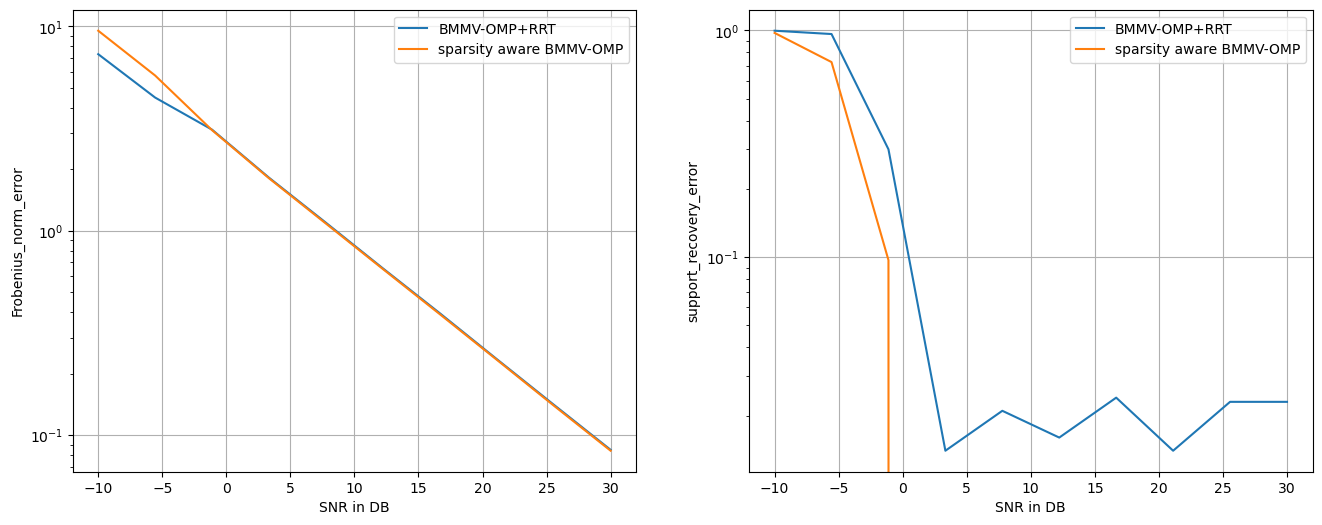

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.semilogy(SNR_db,FRO_ERROR_BMMVOMP,label='BMMV-OMP+RRT')
plt.semilogy(SNR_db,FRO_ERROR_BASELINE,label='sparsity aware BMMV-OMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('Frobenius_norm_error')  

plt.subplot(1,2,2)
plt.semilogy(SNR_db,SUPPORT_ERROR_BMMVOMP,label='BMMV-OMP+RRT')
plt.semilogy(SNR_db,SUPPORT_ERROR_BASELINE,label='sparsity aware BMMV-OMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('support_recovery_error')  